In [1]:
base_dir='/tmp/clustering'
dataset_dir='https://workshopml.spock.cloud/datasets/furniture'

In [2]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-715445047862


In [3]:
%%time
import os
!mkdir -p $base_dir
if not os.path.exists(base_dir + '/furniture.raw.json'):
    !curl $dataset_dir/furniture.raw.json -o $base_dir/furniture.raw.json

CPU times: user 0 ns, sys: 12 ms, total: 12 ms
Wall time: 111 ms


In [13]:
import pandas as pd
import numpy as np

dataset = pd.read_json(base_dir + '/furniture.raw.json')
#dataset.head()
dataset[[ 'id', 'raw_hash', 'image_path']].head()

,id,raw_hash,image_path
0,0,"[0.6901253461837761, 0.564547598361969, 0.7025...",moveis/sofas/image_00000.jpg
1,1,"[0.5431836843490601, 0.567444086074829, 0.7415...",moveis/sofas/image_00001.jpg
2,2,"[0.647202372550964, 0.6822489500045771, 0.7340...",moveis/sofas/image_00002.jpg
3,3,"[0.5275084972381591, 0.617555320262908, 0.6901...",moveis/sofas/image_00003.jpg
4,4,"[0.5264348387718201, 0.5977515578269951, 0.604...",moveis/sofas/image_00004.jpg


In [159]:
labels = dataset['id'].values.tolist()
hashes = dataset['raw_hash'].values.tolist()
images = dataset['image_path'].values.tolist()

train_set = np.array(hashes, dtype='float32')
labels_set = np.array(labels)

In [10]:
from sagemaker import KMeans

data_location = 's3://{}/clustering/data'.format(bucket)
output_location = 's3://{}/clustering/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=100,
                data_location=data_location)

training data will be uploaded to: s3://sagemaker-us-east-1-715445047862/clustering/data
training artifacts will be uploaded to: s3://sagemaker-us-east-1-715445047862/clustering/output


In [11]:
%%time

kmeans.fit(kmeans.record_set(train_set))

INFO:sagemaker:Creating training-job with name: kmeans-2018-05-29-18-04-43-412


....................
Docker entrypoint called with argument(s): train
[05/29/2018 18:07:57 INFO 140165595809600] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[05/29/2018 18:07:57 INFO 140165595809600] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'2048', u'mini_batch_size': u'5000', u'k': u'100', u'force_dense': u'True'}
[05/29/2018 18:07:57 INFO 140165595809600] Fina

===== Job Complete =====
Billable seconds: 103
CPU times: user 2.76 s, sys: 116 ms, total: 2.87 s
Wall time: 3min 46s


In [14]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-05-29-18-12-31-864
INFO:sagemaker:Creating endpoint with name kmeans-2018-05-29-18-04-43-412


---------------------------------------------------------------------------!CPU times: user 344 ms, sys: 8 ms, total: 352 ms
Wall time: 6min 20s


In [18]:
print(kmeans_predictor.endpoint)

kmeans-2018-05-29-18-04-43-412


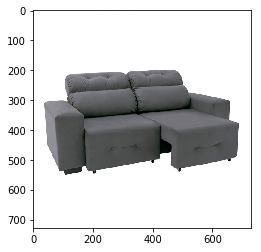

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
plt.imshow(Image.open('/tmp/visual/furniture/moveis/sofas/image_00000.jpg'))

In [141]:
%%time
result = kmeans_predictor.predict(np.array([ train_set[0] ], dtype='float32') )
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 4.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 2.8945813179016113
    }
  }
}
]
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 112 ms


In [ ]:
import sagemaker
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

In [ ]:
for i in train_set:
    result = kmeans_predictor.predict(np.array([ i ], dtype='float32') )
    

In [268]:
images_inside_clusters = {}
for i in images_per_cluster:
    if images_inside_clusters.get(images_per_cluster[i][0]) is None:
        images_inside_clusters[images_per_cluster[i][0]] = []
    images_inside_clusters[images_per_cluster[i][0]].append( i )

In [365]:
!curl -s https://cdn2.iconfinder.com/data/icons/color-svg-vector-icons-part-2/512/undo_arrow_left_edit_back-512.png -o return.png

In [85]:
!curl -s https://www.goat1000.com/tagcanvas.min.js?2.9 -o tagcanvas.min.js

In [191]:
import base64
from io import BytesIO

def get_image_base64(filename):
    image = Image.open( filename )
    image = image.convert("RGBA")
    newData = []
    for item in image.getdata():
        if item[0] >= 253 and item[1] >= 253 and item[2] >= 253:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)

    image.putdata(newData)
    
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode('ascii')
    

In [369]:
import random
from IPython.display import HTML, Javascript, display_javascript

def load_cluster(cluster_id=None):
    ids_images = []
    clusters = []
    furniture_links = ""
    if cluster_id is None:
        clusters = random.sample(range(0,100), 6)
        ids_images = [images_inside_clusters[i][0] for i in clusters]   
    else:
        clusters = [cluster_id for i in range(10)]
        random.shuffle(images_inside_clusters[cluster_id])
        ids_images = [i for i in images_inside_clusters[cluster_id][0:10]]
        furniture_links = '<li><a onclick="loadCluster()" href="#"><img width="10%" height="10%" src="return.png"></img>RETURN</a></li>'
    
    for c,i in zip(clusters, ids_images):
        furniture_links += '<li><a onclick="loadCluster({0})" href="#">'.format(c)
        furniture_links += '<img width="30%" height="30%" src="data:image/png;base64,{0}"></img>'.format(get_image_base64('/tmp/visual/furniture/%s'% images[i] ) )
        furniture_links += 'Cluster: {0}</a></li>'.format(c)

    return furniture_links

In [370]:
HTML('''
<script type="text/javascript" src="tagcanvas.min.js"></script>

<div id="myCanvasContainer">
 <canvas width="600" height="600" id="myCanvas">
  <p>Anything in here will be replaced on browsers that support the canvas element</p>
  <ul id='tags'></ul>
 </canvas>
</div>

<script type="text/javascript">

    function handle_output(out) {
        console.log(out)
        
        document.getElementById('tags').innerHTML = out.content.data["text/plain"];
        
        TagCanvas.Start('myCanvas', 'myCanvasContainer', {
            textColour: '#000000',
            outlineColour: '#ff00ff',
            reverse: true,
            depth: 0.8,
            maxSpeed: 0.05,
            imageMode: 'both',
            imagePosition: 'bottom'
        });

    }

    function loadCluster(id) {
        id = id == undefined ? "":id;
        var kernel = IPython.notebook.kernel;
        var callbacks = { 'iopub' : {'output' : handle_output}};
        //console.log(id)
        resp = kernel.execute("load_cluster(" + id + ")", callbacks, {silent:false});
    }
</script>

''')

In [371]:
jso = Javascript("loadCluster();")
display_javascript(jso)